## Live Demo: SHAP library usage on NIDS summer 2019 team G project.
#### TEAM J
<ul>
    <li> Sotiris Evangelou 2159 </li>
    <li> Konstantinos Kalais 2146 </li>
    <li> Leuteris Chatziefremidis 2209 </li>
</ul>

#### Disclaimer
This is an example of the use of the SHAP library on a real problem, in order to gain insight about the data used, learn what affects the model's predictions and explain them. This code is part of our Project for the Machine Learning course, a Network Intrusion Detection System that gets .pcap variables as input and solves a supervised multiclass classification problem to check whether there is an ongoing cyber attack, and what category it falls into.
The <b>code</b> can be found in this <a href=https://github.com/EvangelouSotiris/NIDS_Project_CE417> Github repository </a>

Some changes have been made to the code. For this example we will see the usage of SHAP library on the use of Random Forest for multiclass classification in Network Intrusion Detection systems.

In [59]:
import sys
import time
from dataset_prepare import prepare_data
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.utils import np_utils as npu
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import shap
from IPython.display import display
import pandas as pd 
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from feature_selector import FeatureSelector

def clean_nominals_and_create_our_datasets(train_set_df,test_set_df):
    #Get nominal columns
    nominal_cols = train_set_df.select_dtypes(include='object').columns.tolist()
    #Turn nominal to numeric train and testX
    for nom in nominal_cols:
        le = LabelEncoder()
        le.fit(train_set_df[nom])
        train_set_df[nom]=le.transform(train_set_df[nom])
        testEnc = LabelEncoder()
        testEnc.classes_=le.classes_
        testEnc.fit(test_set_df[nom])
        test_set_df[nom] =testEnc.transform(test_set_df[nom])
        print(dict(zip(testEnc.classes_, testEnc.transform(testEnc.classes_))))
    classes = dict(zip(testEnc.classes_, testEnc.transform(testEnc.classes_)))

    # drop the nominal columns from the initial set
    train_set_df_y = train_set_df.attack_cat
    train_Y = np.array(train_set_df_y)
    train_Y = train_Y.reshape((train_Y.shape[0],1))
    train_set_df = train_set_df.drop(["attack_cat","label"], axis=1)
    train_X = np.array(train_set_df)

    test_set_df_y = test_set_df.attack_cat
    test_set_df_y1 = test_set_df.label
    test_Y = np.array(test_set_df_y)
    test_Y = test_Y.reshape((test_Y.shape[0],1))
    test_set_df = test_set_df.drop(["attack_cat","label"], axis=1)
    test_X = np.array(test_set_df)

    labels = np.array(test_set_df_y1)
    labels = labels.reshape((labels.shape[0],1))
    
    return train_X,train_Y,test_X,test_Y,test_set_df,labels, classes

def prepare_data(): 
    """
    This function is the main of this module. calls the above functions in order to read/clean/save
    our data in usable form.
    I created this function to use dataset_prepare.py as a Python module in our main program.
    
    Return values: training X,Y dataset and testing X,Y dataset
    """

    # read our csv files
    features_df = pd.read_csv("UNSW_NB15_features.csv",encoding = "ISO-8859-1")
    training_df = pd.read_csv("training.csv").drop("id",axis=1)
    testing_df = pd.read_csv("testing.csv").drop("id",axis=1)

    fs = FeatureSelector(data = training_df)
    fs.identify_collinear(correlation_threshold=0.85)
    training_df = fs.remove(methods = ['collinear'],keep_one_hot = True)
    columnlist = list(training_df)
    testing_df = testing_df[columnlist]
    
    training_df = training_df.sample(frac=1)
    testing_df = testing_df.sample(frac=1)
    train_x,train_y,test_x,test_y, testing_df, labels, classes = clean_nominals_and_create_our_datasets(training_df,testing_df)

    training_df = training_df.drop(["attack_cat","label"], axis=1)
    training_df = np.array(list(training_df))
    print("The features we will use are: ")
    for i in range(len(training_df)):
        print("["+ str(i) +"]: " + str(training_df[i]))

    return train_x,train_y,test_x,test_y,testing_df,labels, classes, training_df


if __name__ == '__main__':
    """
    This function performs classification with random forest.
    In order to call it please run with "$ python3 ids.py randomforest"

    """
    train_x,train_y,test_x,test_y ,testxdf, labels, classes, traindf= prepare_data()
    train_y = train_y.reshape((train_y.shape[0],))
    clf = RandomForestClassifier(n_estimators=1000, max_depth=5,random_state=None)
    
    start = time.time()
    clf.fit(train_x,train_y)
    end = time.time()
        
    yhat = clf.predict(test_x)
    for i in range(len(yhat)):
        if yhat[i] == 6:
            yhat[i] = 0 
        else:
            yhat[i] = 1
    correct_class = 0
    for i in range(len(labels)):
        if labels[i] == yhat[i]:
            correct_class += 1

    print("\n## Time ##")
    print("Training lasted {} seconds".format(end-start))
    print("\n## Accuracies ##")
    print("Normal/Abnormal activity accuracy:{}%".format((correct_class/len(labels))*100))
    print("Attack type classification accuracy: {}%".format(clf.score(test_x,test_y)*100))

No labels provided. Feature importance based methods are not available.
14 features with a correlation magnitude greater than 0.85.

Removed 14 features.
{'3pc': 0, 'a/n': 1, 'aes-sp3-d': 2, 'any': 3, 'argus': 4, 'aris': 5, 'arp': 6, 'ax.25': 7, 'bbn-rcc': 8, 'bna': 9, 'br-sat-mon': 10, 'cbt': 11, 'cftp': 12, 'chaos': 13, 'compaq-peer': 14, 'cphb': 15, 'cpnx': 16, 'crtp': 17, 'crudp': 18, 'dcn': 19, 'ddp': 20, 'ddx': 21, 'dgp': 22, 'egp': 23, 'eigrp': 24, 'emcon': 25, 'encap': 26, 'etherip': 27, 'fc': 28, 'fire': 29, 'ggp': 30, 'gmtp': 31, 'gre': 32, 'hmp': 33, 'i-nlsp': 34, 'iatp': 35, 'ib': 36, 'idpr': 37, 'idpr-cmtp': 38, 'idrp': 39, 'ifmp': 40, 'igmp': 41, 'igp': 42, 'il': 43, 'ip': 44, 'ipcomp': 45, 'ipcv': 46, 'ipip': 47, 'iplt': 48, 'ipnip': 49, 'ippc': 50, 'ipv6': 51, 'ipv6-frag': 52, 'ipv6-no': 53, 'ipv6-opts': 54, 'ipv6-route': 55, 'ipx-n-ip': 56, 'irtp': 57, 'isis': 58, 'iso-ip': 59, 'iso-tp4': 60, 'kryptolan': 61, 'l2tp': 62, 'larp': 63, 'leaf-1': 64, 'leaf-2': 65, 'merit-i

<h4> <i> The above part was the main program </i> </h4>
What we added to it was structures that keep the nominal to arithmetic transformation values, and pandas dataframes that will be used for the SHAP plots.

#### The classes that attacks are classified as are:

In [60]:
print("Classes")
for classs in classes:
    print("[" + str(classes[classs]) +"]" + str(classs))

Classes
[0]Analysis
[1]Backdoor
[2]DoS
[3]Exploits
[4]Fuzzers
[5]Generic
[6]Normal
[7]Reconnaissance
[8]Shellcode
[9]Worms


#### Shap values are the most important part of the lib utility, and they show the impact that a feature has in changing the output of the model.

In [71]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(testxdf[:1000])
print(len(shap_values),len(shap_values[0]))
print("A list for each class, a value for each instance.")

10 1000
A list for each class, a value for each instance.


In [80]:
shap.initjs() # for the graphics

#### The average impact of the top 20 features on the model's output

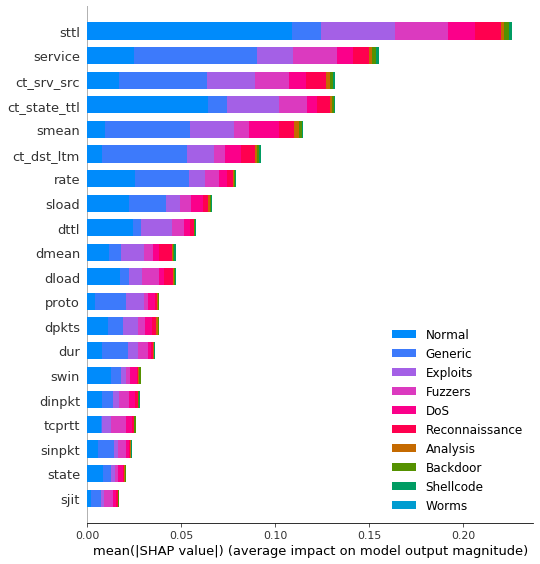

None

In [73]:
classnames = [x for x in classes.keys()]
display(shap.summary_plot(shap_values, testxdf, class_names=classnames))

#### Feature importance on DoS attacks

FEATURE IMPORTANCE ON DoS ATTACKS


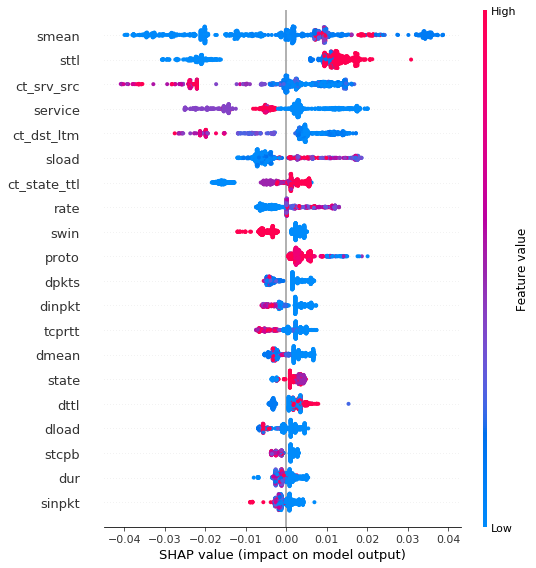

None

In [75]:
display(shap.summary_plot(shap_values[classes['DoS']], testxdf[:1000], feature_names=traindf))

We can observe that the 'sttl' has a huge impact on classification as DoS attack as it gets high numbers, contrary to 'ct_srv_src' feature, that lowers the chance to classify as a DoS attack when it is in low numbers.

#### Feature SHAP values in regard to DoS classification on 1000 instances

In [82]:
display(shap.force_plot(explainer.expected_value[classes['DoS']], shap_values[classes['DoS']], testxdf[:1000]))    

#### An easier approach is to get instances that should be classified as DoS attacks , and check feature trends.

In [79]:
a = []
for i in range(len(test_y)):
    if test_y[i] == classes['DoS']:
        a.append(i)
for i in range(10):
    display(shap.force_plot(explainer.expected_value[classes['DoS']], shap_values[classes['DoS']][a[i],:], testxdf.iloc[a[i],:], feature_names=traindf))